In [1]:
pip install holidays

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.2/378.2 kB 7.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 33.0 MB/s eta 0:00:00:00:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 10.4 MB/s eta 0:00:00
  Created wheel for PyMeeus: filename=PyMeeus-0.5.12-py3-none-any.whl size=731999 sha256=8e769d65ab9b2680e2056ebe529fca45879e77d80683b2902c1656a2622a27e1
  Stored in directory: /home/ec2-user/.cache/pip/wheels/74/47/c4/678b0a3d5213e2f8500f3ea0f8dc3c81478e5b806c557dff58
Successfully built PyMeeus
Note: you may need to restart the kernel to use updated packages.


In [2]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

from tqdm import tqdm

import holidays

from functools import partial
import scipy as sp

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns

from scipy.stats import rankdata
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, StratifiedKFold, TimeSeriesSplit, GroupKFold
from sklearn.metrics import mean_squared_error, roc_auc_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, HistGradientBoostingClassifier, HistGradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, ElasticNet

s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'Tabular-Playground-Series/Pog-Series/Rob-Sleep-Prediction/train.csv'
file_key_2 = 'Tabular-Playground-Series/Pog-Series/Rob-Sleep-Prediction/test.csv'
file_key_3 = 'Tabular-Playground-Series/Pog-Series/Rob-Sleep-Prediction/sample_submission.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

bucket_object_3 = bucket.Object(file_key_3)
file_object_3 = bucket_object_3.get()
file_content_stream_3 = file_object_3.get('Body')

## Reading data files
train = pd.read_csv(file_content_stream_1)
train['date'] = pd.to_datetime(train['date'])

test = pd.read_csv(file_content_stream_2)
test['date'] = pd.to_datetime(test['date'])

submission = pd.read_csv(file_content_stream_3)

# Feature Engineering

In [3]:
def get_holidays(df):
    years_list = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

    holiday_US = holidays.CountryHoliday('US', years = years_list)
    holiday_dict = holiday_US.copy()

    df['holiday_name'] = df['date'].map(holiday_dict)
    df['is_holiday'] = np.where(df['holiday_name'].notnull(), 1, 0)
    df['holiday_name'] = df['holiday_name'].fillna('Not Holiday')
    
#     return df
    return df.drop(columns = ['holiday_name'])


def feature_engineer(df):
    
    new_df = df.copy()
    new_df["month"] = df["date"].dt.month
    new_df["month_sin"] = np.sin(new_df['month'] * (2 * np.pi / 12))
#     new_df["month_cos"] = np.cos(new_df['month'] * (2 * np.pi / 12))
    
    new_df["day"] = df["date"].dt.day
    new_df["day_sin"] = np.sin(new_df['day'] * (2 * np.pi / 12))
#     new_df["day_cos"] = np.cos(new_df['day'] * (2 * np.pi / 12))
    
    new_df["day_of_week"] = df["date"].dt.dayofweek
#     new_df["day_of_week"] = new_df["day_of_week"].apply(lambda x: 0 if x <= 3 else(1 if x == 4 else (2 if x == 5 else (3))))
    
    new_df["day_of_year"] = df["date"].dt.dayofyear
    new_df["year"] = df["date"].dt.year
    
    return new_df

train = feature_engineer(train)
test = feature_engineer(test)

train = get_holidays(train)
test = get_holidays(test)

train.loc[((train['date'] >= '2017-09-27') & (train['date'] <= '2018-06-12')), 'sleep_hours'] = train.loc[((train['date'] >= '2017-09-27') & (train['date'] <= '2018-06-12')), 'sleep_hours'] / 1.94 

X = train.drop(columns = ['date', 'sleep_hours', 'year'], axis = 1)
Y = train['sleep_hours']

test = test.drop(columns = ['date', 'sleep_hours', 'year'], axis = 1)

train = train[train['date'] > '2015-07-20'].reset_index(drop = True)

# Visualization

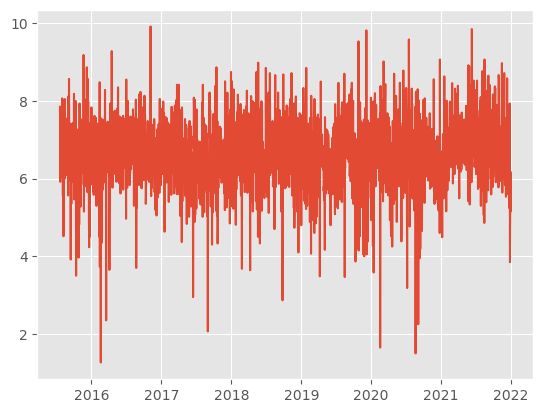

In [4]:
plt.plot('date', 'sleep_hours', data = train);

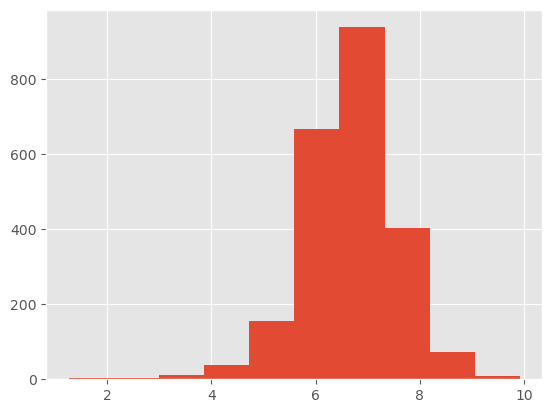

In [5]:
plt.hist('sleep_hours', data = train);

In [6]:
train[train['sleep_hours'] > 8].shape

(117, 10)

In [7]:
train[train['sleep_hours'] < 4].shape

(23, 10)

In [19]:
train[train['is_holiday'] == 1]

,date,sleep_hours,month,month_sin,day,day_sin,day_of_week,day_of_year,year,is_holiday
46,2015-09-07,6.900000,9,-1.000000e+00,7,-5.000000e-01,0,250,2015,1
81,2015-10-12,6.116667,10,-8.660254e-01,12,-2.449294e-16,0,285,2015,1
111,2015-11-11,6.950000,11,-5.000000e-01,11,-5.000000e-01,2,315,2015,1
126,2015-11-26,6.666667,11,-5.000000e-01,26,8.660254e-01,3,330,2015,1
155,2015-12-25,7.333333,12,-2.449294e-16,25,5.000000e-01,4,359,2015,1
...,...,...,...,...,...,...,...,...,...,...
2254,2021-11-11,7.233333,11,-5.000000e-01,11,-5.000000e-01,3,315,2021,1
2267,2021-11-25,7.241667,11,-5.000000e-01,25,5.000000e-01,3,329,2021,1
2296,2021-12-24,5.233333,12,-2.449294e-16,24,-4.898587e-16,4,358,2021,1
2297,2021-12-25,7.933333,12,-2.449294e-16,25,5.000000e-01,5,359,2021,1


<AxesSubplot: >

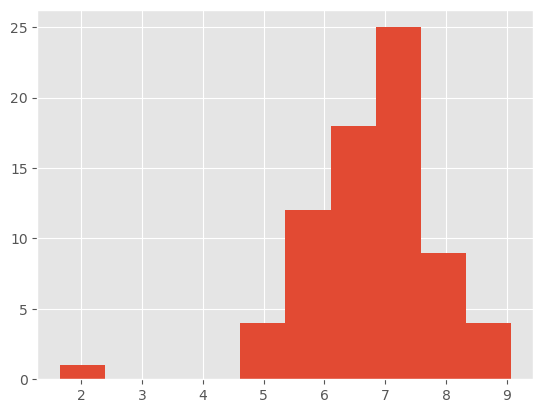

In [21]:
train[train['is_holiday'] == 1]['sleep_hours'].hist()

In [24]:
train[(train['is_holiday'] == 1) & (train['sleep_hours'] < 4)]

,date,sleep_hours,month,month_sin,day,day_sin,day_of_week,day_of_year,year,is_holiday
1635,2020-02-17,1.65,2,0.866025,17,0.5,0,48,2020,1


In [8]:
train['sleep_hours'].describe()

count    2302.000000
mean        6.663792
std         0.902770
min         1.266667
25%         6.166667
50%         6.683333
75%         7.233333
max         9.916667
Name: sleep_hours, dtype: float64

# Removing Outliers

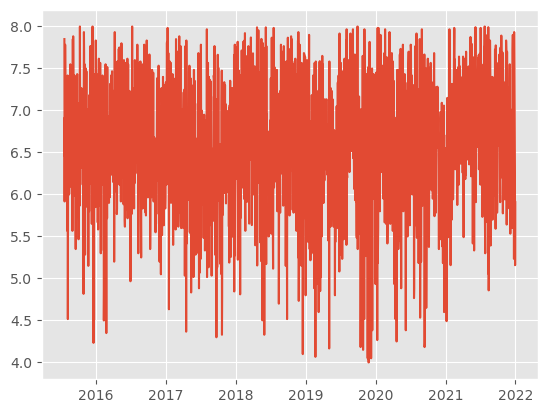

In [11]:
train = train[~((train['sleep_hours'] < 4) | (train['sleep_hours'] > 8))].reset_index()
plt.plot('date', 'sleep_hours', data = train);

In [14]:
train[train['sleep_hours'] > 7]

,level_0,index,date,sleep_hours,month,month_sin,day,day_sin,day_of_week,day_of_year,year,is_holiday
0,0,0,2015-07-21,7.850000,7,-5.000000e-01,21,-1.000000e+00,1,202,2015,0
4,4,4,2015-07-25,7.783333,7,-5.000000e-01,25,5.000000e-01,5,206,2015,0
11,12,12,2015-08-04,7.100000,8,-8.660254e-01,4,8.660254e-01,1,216,2015,0
13,14,14,2015-08-06,7.250000,8,-8.660254e-01,6,1.224647e-16,3,218,2015,0
14,15,15,2015-08-07,7.416667,8,-8.660254e-01,7,-5.000000e-01,4,219,2015,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2146,2285,2285,2021-12-13,7.008333,12,-2.449294e-16,13,5.000000e-01,0,347,2021,0
2150,2289,2289,2021-12-17,7.725000,12,-2.449294e-16,17,5.000000e-01,4,351,2021,0
2151,2290,2290,2021-12-18,7.900000,12,-2.449294e-16,18,3.673940e-16,5,352,2021,0
2156,2295,2295,2021-12-23,7.433333,12,-2.449294e-16,23,-5.000000e-01,3,357,2021,0


In [15]:
train[train['sleep_hours'] > 7]['day_of_week'].value_counts()

5    120
4    115
3    107
6    107
2     82
1     76
0     76
Name: day_of_week, dtype: int64

In [16]:
train[train['sleep_hours'] > 7]['month'].value_counts()

8     71
9     62
2     61
7     59
10    59
11    59
1     59
3     58
4     54
12    49
5     48
6     44
Name: month, dtype: int64

In [18]:
train[(train['sleep_hours'] > 7) & (train['is_holiday'] == 1) & (train['month'] <= 3)]

,level_0,index,date,sleep_hours,month,month_sin,day,day_sin,day_of_week,day_of_year,year,is_holiday
150,162,162,2016-01-01,7.833333,1,0.500000,1,0.500000,4,1,2016,1
495,523,523,2017-01-01,7.333333,1,0.500000,1,0.500000,6,1,2017,1
510,538,538,2017-01-16,7.350000,1,0.500000,16,0.866025,0,16,2017,1
832,876,876,2018-01-01,7.525773,1,0.500000,1,0.500000,0,1,2018,1
1880,1990,1990,2021-02-15,7.983333,2,0.866025,15,1.000000,0,46,2021,1


In [12]:
linear_preds = np.zeros(test.shape[0])
linear_rmse = 0

ridge_preds = np.zeros(test.shape[0])
ridge_rmse = 0

lasso_preds = np.zeros(test.shape[0])
lasso_rmse = 0

elastic_preds = np.zeros(test.shape[0])
elastic_rmse = 0

kf = KFold(n_splits = 30, shuffle = True, random_state = 42)
# kf = GroupKFold(n_splits = 5)

for trn_idx, test_idx in kf.split(X, Y):
# for trn_idx, test_idx in kf.split(X, groups = X.year):
    
    x_train, x_valid = X.iloc[trn_idx], X.iloc[test_idx]
    y_train, y_valid = Y.iloc[trn_idx], Y.iloc[test_idx]
    
    ##################
    ## Linear model ##
    ##################
    
    linear_model = LinearRegression().fit(x_train, y_train)

    y_pred = linear_model.predict(x_valid)
    linear_rmse += mean_squared_error(y_pred, y_valid, squared = False) / kf.n_splits
    
    linear_pred = linear_model.predict(test)
    linear_pred = pd.Series(linear_pred) 
    linear_preds += linear_pred / kf.n_splits
    
    ###########
    ## Ridge ##
    ###########
    
    ridge_model = Ridge(alpha = 0.0999, tol = 1e-2, max_iter = 1000000, random_state = 0).fit(x_train, y_train)

    y_pred = ridge_model.predict(x_valid)
    ridge_rmse += mean_squared_error(y_pred, y_valid, squared = False) / kf.n_splits
    
    ridge_pred = ridge_model.predict(test)
    ridge_pred = pd.Series(ridge_pred) 
    ridge_preds += ridge_pred / kf.n_splits
    
    ###########
    ## Lasso ##
    ###########
    
    lasso_model = Lasso(alpha = 0.0999, tol = 1e-2, max_iter = 1000000, random_state = 0).fit(x_train, y_train)

    y_pred = lasso_model.predict(x_valid)
    lasso_rmse += mean_squared_error(y_pred, y_valid, squared = False) / kf.n_splits
    
    lasso_pred = lasso_model.predict(test)
    lasso_pred = pd.Series(lasso_pred) 
    lasso_preds += lasso_pred / kf.n_splits
    
    #############
    ## Elastic ##
    #############
    
    elastic_model = ElasticNet(alpha = 0.0002, l1_ratio = 0.001, random_state = 42).fit(x_train, y_train)

    y_pred = elastic_model.predict(x_valid)
    elastic_rmse += mean_squared_error(y_pred, y_valid, squared = False) / kf.n_splits
    
    elastic_pred = elastic_model.predict(test)
    elastic_pred = pd.Series(elastic_pred) 
    elastic_preds += elastic_pred / kf.n_splits 

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.351e+02, tolerance: 1.928e-01
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.402e+02, tolerance: 1.940e-01
  model = cd_fast.enet_coordinate_descent(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

In [13]:
md_perf = pd.DataFrame({'Model': ['Linear', 'Ridge', 'Lasso', 'Elastic'], 
                        'CV-Score': [linear_rmse, ridge_rmse, lasso_rmse, elastic_rmse]})
md_perf

,Model,CV-Score
0,Linear,0.900078
1,Ridge,0.900050
2,Lasso,0.900456
3,Elastic,0.900074
